
### TrioLearn: ILD@K Comparison Across Courses, Books, and Videos

- Loads 3 modality CSVs (courses, books, videos)
- Builds simple TF-IDF recommenders per modality
- Computes ILD@K for a shared set of realistic queries
- Prints per-query ILD and a modality comparison summary



In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

In [2]:
K = 10
QUERIES = [
    "deep learning",
    "natural language processing",
    "data visualization",
    "graph neural networks",
    "probabilistic programming",
    "SQL databases",
    "computer vision",
    "transformers for NLP",
    "bayesian inference",
    "recommender systems",
    "mlops pipelines",
    "time series forecasting",
]

In [4]:

COURSES_CSV = "C:/Users/jvlas/source/repos/TrioLearn/backend/data/interim/courses_metadata.csv"
BOOKS_CSV   = "C:/Users/jvlas/source/repos/TrioLearn/backend/data/interim/books_metadata.csv"
VIDEOS_CSV  = "C:/Users/jvlas/source/repos/TrioLearn/backend/data/interim/videos_metadata.csv"

# Preferred text columns per modality; script will auto-detect those that exist.
PREFERRED_TEXT_COLS = {
    "courses": ["title", "description", "skills", "tags", "summary"],
    "books":   ["title", "description", "subtitle", "subjects"],
    "videos":  ["title", "description", "channel_title", "tags"],
}

TITLE_COL_FALLBACKS = ["title", "name", "book_title", "course_title", "video_title"]



In [5]:
def build_index(texts, max_features=50000, ngram_range=(1,2), stop_words='english'):
    vec = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    X = vec.fit_transform(texts)
    Xn = normalize(X)
    return vec, Xn

def recommend(query, vec, Xn, k=10):
    qv = vec.transform([query])
    qv = normalize(qv)
    sims = (qv @ Xn.T).toarray().ravel()
    k = min(k, Xn.shape[0])
    if k == 0:
        return np.array([], dtype=int), np.array([])
    topk = np.argpartition(-sims, k-1)[:k]
    topk = topk[np.argsort(-sims[topk])]
    return topk, sims[topk]

def ild_at_k(indices, Xn):
    if len(indices) <= 1:
        return 0.0
    A = Xn[indices]
    S = (A @ A.T).toarray()
    K_ = len(indices)
    triu_idx = np.triu_indices(K_, k=1)
    cos_pairs = S[triu_idx]
    return float(np.mean(1.0 - cos_pairs)) if cos_pairs.size else 0.0

def average_ild(queries, vec, Xn, K=10, verbose=True, modality_name=""):
    scores = []
    for q in queries:
        idxs, _ = recommend(q, vec, Xn, k=K)
        ild = ild_at_k(idxs, Xn)
        scores.append(ild)
        if verbose:
            print(f"[{modality_name}] ILD@{K} for {q!r}: {ild:.3f}")
    mean_ild = float(np.mean(scores)) if scores else 0.0
    std_ild  = float(np.std(scores))  if scores else 0.0
    print(f"\n[{modality_name}] Average ILD@{K} over {len(queries)} queries: {mean_ild:.3f} ± {std_ild:.3f}\n")
    return mean_ild, std_ild

In [6]:
def pick_existing_columns(df, preferred_list):
    return [c for c in preferred_list if c in df.columns]

def find_title_col(df):
    for c in TITLE_COL_FALLBACKS:
        if c in df.columns:
            return c
    # fallback to the first object-like column
    for c in df.columns:
        if pd.api.types.is_string_dtype(df[c]):
            return c
    return df.columns[0]

def load_texts_and_titles(csv_path, preferred_text_cols):
    if not os.path.exists(csv_path):
        print(f"[skip] File not found: {csv_path}")
        return None, None
    df = pd.read_csv(csv_path)
    text_cols = pick_existing_columns(df, preferred_text_cols)
    if not text_cols:
        # If none of the preferred exist, try to use all string columns
        text_cols = [c for c in df.columns if pd.api.types.is_string_dtype(df[c])]
    if not text_cols:
        print(f"[skip] No usable text columns in: {csv_path}")
        return None, None

    # Build texts by concatenating available text columns
    texts = df[text_cols].fillna("").astype(str).agg(" ".join, axis=1).tolist()

    # Titles for reporting
    title_col = find_title_col(df)
    titles = df[title_col].fillna("").astype(str).tolist()
    return texts, titles

In [7]:
def evaluate_modality(name, csv_path, preferred_cols, queries, K=10):
    texts, titles = load_texts_and_titles(csv_path, preferred_cols)
    if texts is None:
        return None
    if len(texts) == 0:
        print(f"[skip] Empty corpus for {name}")
        return None
    vec, Xn = build_index(texts)
    mean_ild, std_ild = average_ild(queries, vec, Xn, K=K, verbose=True, modality_name=name)
    return {"modality": name, "n_docs": len(texts), "mean_ild": mean_ild, "std_ild": std_ild}


In [8]:
results = []

courses_res = evaluate_modality(
    "courses",
    COURSES_CSV,
    PREFERRED_TEXT_COLS["courses"],
    QUERIES,
    K=K,
)
if courses_res:
    results.append(courses_res)

books_res = evaluate_modality(
    "books",
    BOOKS_CSV,
    PREFERRED_TEXT_COLS["books"],
    QUERIES,
    K=K,
)
if books_res:
    results.append(books_res)

videos_res = evaluate_modality(
    "videos",
    VIDEOS_CSV,
    PREFERRED_TEXT_COLS["videos"],
    QUERIES,
    K=K,
)
if videos_res:
    results.append(videos_res)

if not results:
    print("\nNo modalities evaluated. Check file paths and columns.")
else:
    # Summary table
    print(f"\n=== ILD@{K} Summary Across Modalities ===")
    df = pd.DataFrame(results, columns=["modality", "n_docs", "mean_ild", "std_ild"])
    
    # Nicely formatted print
    with pd.option_context('display.max_columns', None, 'display.width', 120):
        display(df)  # Jupyter-friendly (renders as a table instead of plain text)

    # Highlight the best mean_ild
    best = max(results, key=lambda r: r["mean_ild"])
    print(f"\nBest diversity (ILD@{K}): {best['modality']} — "
          f"{best['mean_ild']:.3f} ± {best['std_ild']:.3f} "
          f"on n={best['n_docs']} docs")


[courses] ILD@10 for 'deep learning': 0.821
[courses] ILD@10 for 'natural language processing': 0.929
[courses] ILD@10 for 'data visualization': 0.884
[courses] ILD@10 for 'graph neural networks': 0.904
[courses] ILD@10 for 'probabilistic programming': 0.924
[courses] ILD@10 for 'SQL databases': 0.888
[courses] ILD@10 for 'computer vision': 0.934
[courses] ILD@10 for 'transformers for NLP': 0.982
[courses] ILD@10 for 'bayesian inference': 0.928
[courses] ILD@10 for 'recommender systems': 0.878
[courses] ILD@10 for 'mlops pipelines': 0.906
[courses] ILD@10 for 'time series forecasting': 0.968

[courses] Average ILD@10 over 12 queries: 0.912 ± 0.041

[books] ILD@10 for 'deep learning': 0.557
[books] ILD@10 for 'natural language processing': 0.541
[books] ILD@10 for 'data visualization': 0.682
[books] ILD@10 for 'graph neural networks': 0.695
[books] ILD@10 for 'probabilistic programming': 0.791
[books] ILD@10 for 'SQL databases': 0.710
[books] ILD@10 for 'computer vision': 0.647
[books] 

,modality,n_docs,mean_ild,std_ild
0,courses,623,0.912140,0.040966
1,books,3507,0.735215,0.113247
2,videos,1000,0.847727,0.098692



Best diversity (ILD@10): courses — 0.912 ± 0.041 on n=623 docs


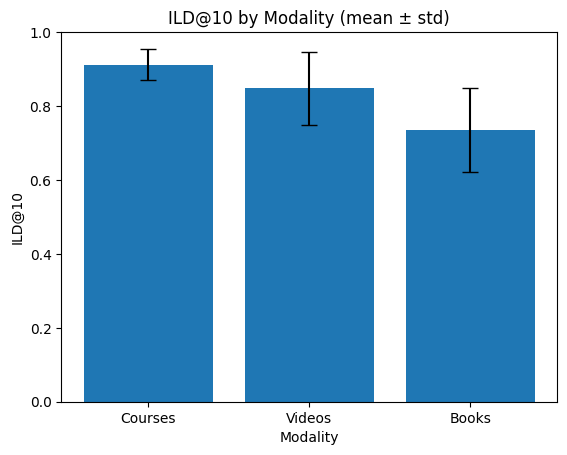

In [9]:
import matplotlib.pyplot as plt

modalities = ["Courses", "Videos", "Books"]
means = [0.912, 0.848, 0.735]
stds  = [0.041, 0.099, 0.113]

plt.figure()
plt.bar(modalities, means, yerr=stds, capsize=6)
plt.ylim(0, 1.0)
plt.title("ILD@10 by Modality (mean ± std)")
plt.xlabel("Modality")
plt.ylabel("ILD@10")
plt.show()
